In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sc.settings.verbosity = 3
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 140
sns.set(font="Arial", font_scale=1, style='ticks')
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#104e8b", "#ffdab9", "#8b0a50"])

dir = "/Users/mhryansohn/Desktop/01.Workspace/01.Projects/02.WC300/01.Multi-Omics"
clinic_info = pd.read_csv(f'{dir}/2022_WC300_clinical_information_Xadded_ver2.0.csv', index_col='Sample')

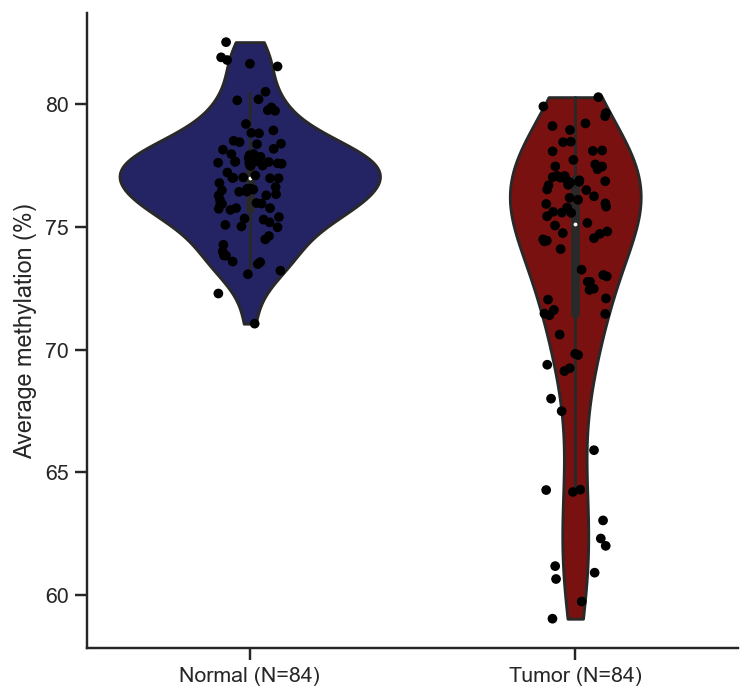

In [16]:
# Average methylation for Tumor vs Normal (Figure 1)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.violinplot(data=clinic_info.iloc[84:][['PercentMet_COV5_Normal', 'PercentMet_COV5_Tumor']], palette={'PercentMet_COV5_Normal':'midnightblue', 'PercentMet_COV5_Tumor':'darkred'}, cut=0, scale="area", ax=ax)
sns.stripplot(data=clinic_info.iloc[84:][['PercentMet_COV5_Normal', 'PercentMet_COV5_Tumor']], color="black", ax=ax)
ax.set_xticklabels(['Normal (N=84)', 'Tumor (N=84)'])
ax.set_ylabel("Average methylation (%)")
sns.despine(ax=ax)

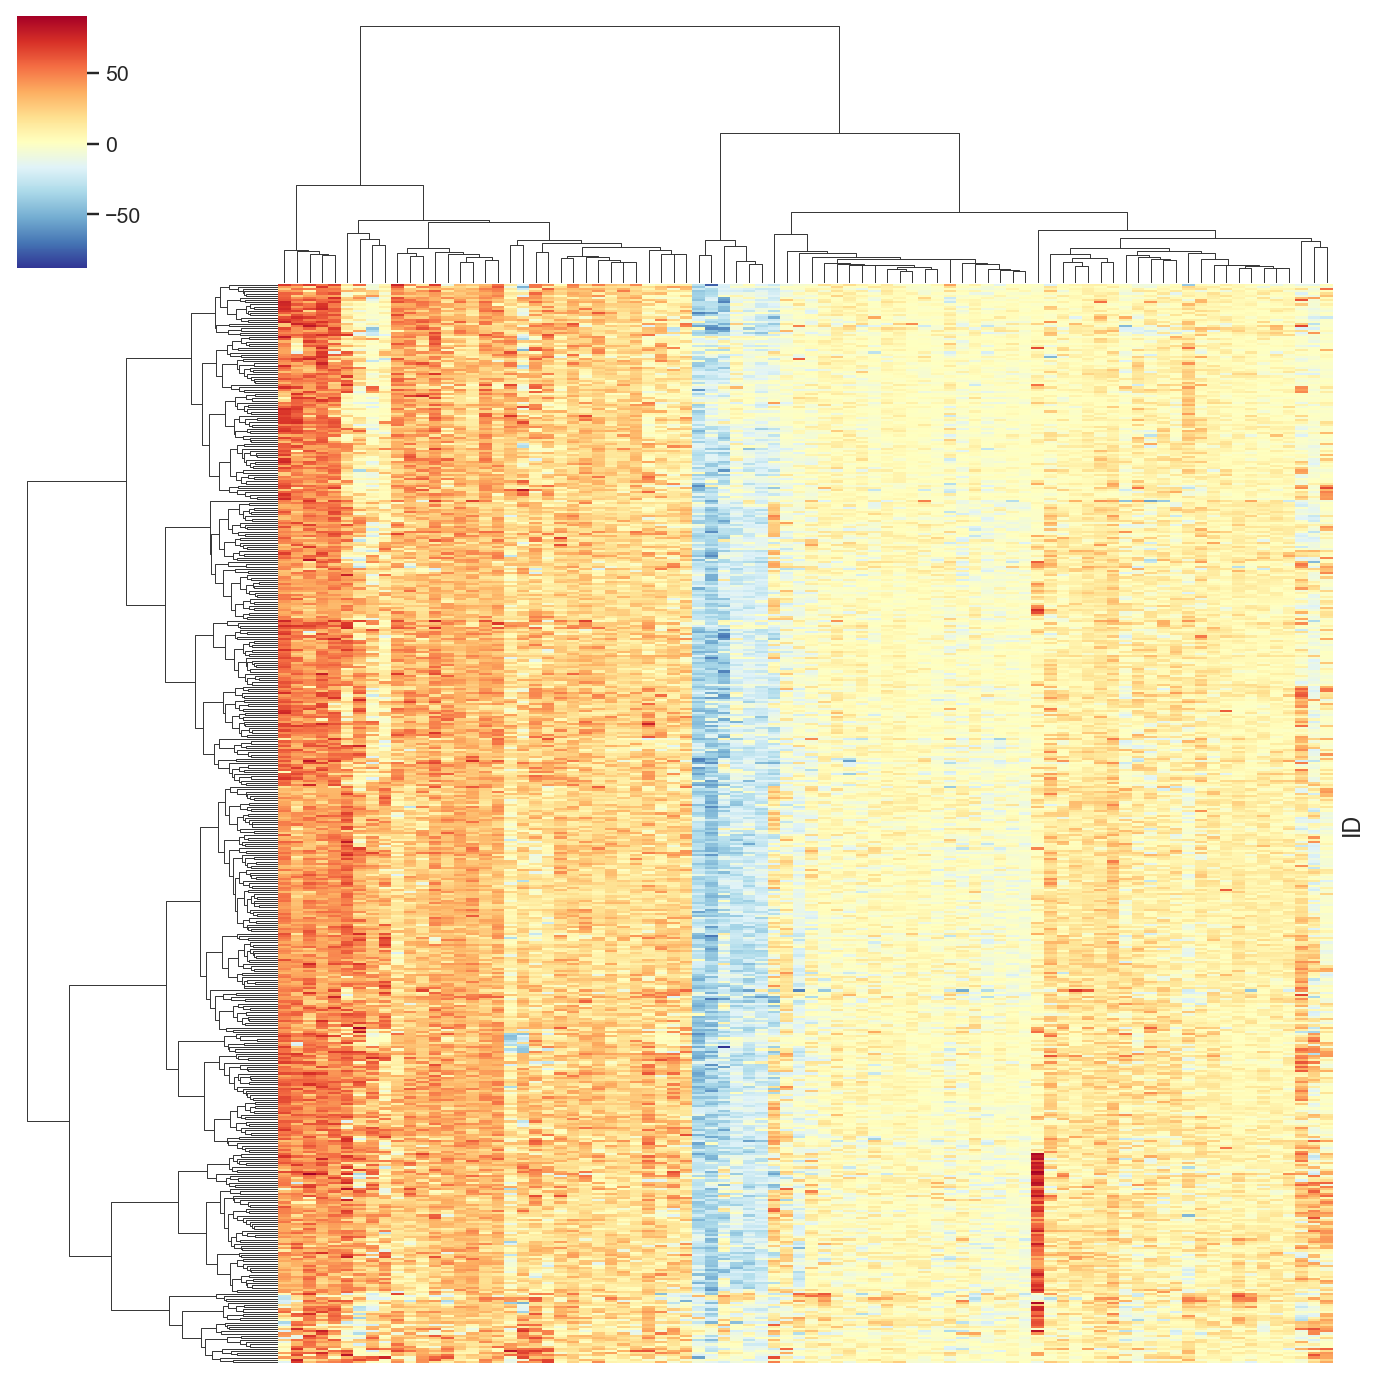

In [19]:
## Determining CIMP Tumors
# Call CpGi methylation
cpgi_met = pd.read_table(f"{dir}/01.DNA_Methylation/CpG_Islands/CpGi_smooth.txt", index_col=0)
cpgi_met = cpgi_met * 100

# Column name change
cpgi_met.columns = list(map(lambda x: 'X'+x, cpgi_met.columns))

# Discard missing CpGi DNA methylation rows & pick CpGi sites where Normal DNA methylation < 40
cpgi_met = cpgi_met[cpgi_met.iloc[:, :84].mean(axis=1) < 40] # (i)
#cpgi_met = cpgi_met[cpgi_met.iloc[:, :84].mean(axis=1) < 20] # (ii)
# Call Promoter CpGi
cpgi_pls = list(map(lambda x: x.strip('\n').split('/')[0], open(f"{dir}/01.DNA_Methylation/CpG_Islands/PLS_CpGi.txt", 'r').readlines()))

# Select Promoter CpGi
cpgi_pls_met = cpgi_met[cpgi_met.index.isin(cpgi_pls)]

# mean(Tumor - Normal) >= 10%
cpgi_pls_tn_met = cpgi_pls_met.iloc[:, 84:] - cpgi_pls_met.iloc[:, :84].values
cpgi_pls_tn_met = cpgi_pls_tn_met[cpgi_pls_tn_met.mean(axis=1) >= 10]

# Hierarchical clustering

g = sns.clustermap(cpgi_pls_tn_met,
                   method='ward',
                   metric='euclidean',
                   z_score=None,
                   standard_scale=None,
                   cmap='RdYlBu_r',
                   xticklabels=False,
                   yticklabels=False,
                   col_colors=None)


In [21]:
cimp_positive_samples = list(cpgi_pls_tn_met.iloc[:, g.dendrogram_col.reordered_ind[:33]].columns) # (i)
total_sample_cimp_info = list(map(lambda x: 'CIMP(+) tumor (N=33)' if x in cimp_positive_samples else ('Normal (N = 84)' if x[-1] == 'N' else 'CIMP(-) tumor (N = 51)'), cpgi_pls_met.columns))
total_sample_cimp_info = pd.Series(dict(zip(list(cpgi_pls_met.columns), total_sample_cimp_info)))

# Partially Methylated Domains (PMDs)
pmd_met = pd.read_table(f"{dir}/01.DNA_Methylation/PMD_ALL.txt", index_col=0)
pmd_met.columns = list(map(lambda x: 'X'+x, pmd_met.columns))
normal_pmd = pmd_met.iloc[:, :84].mean()
tumor_pmd = pmd_met.iloc[:, 84:].mean()

# Association between PMD methylation and CIMP-CGI DNA methylation
cimp_pmd = pd.concat([cpgi_pls_met[cpgi_pls_met.index.isin(cpgi_pls_tn_met.index)].mean(), pmd_met.mean(), total_sample_cimp_info], axis=1)
cimp_pmd.columns = ['CpGimet', 'PMDmet', 'CIMPtype']
rho = round(stats.spearmanr(cimp_pmd['CpGimet'], cimp_pmd['PMDmet'])[0], 3)

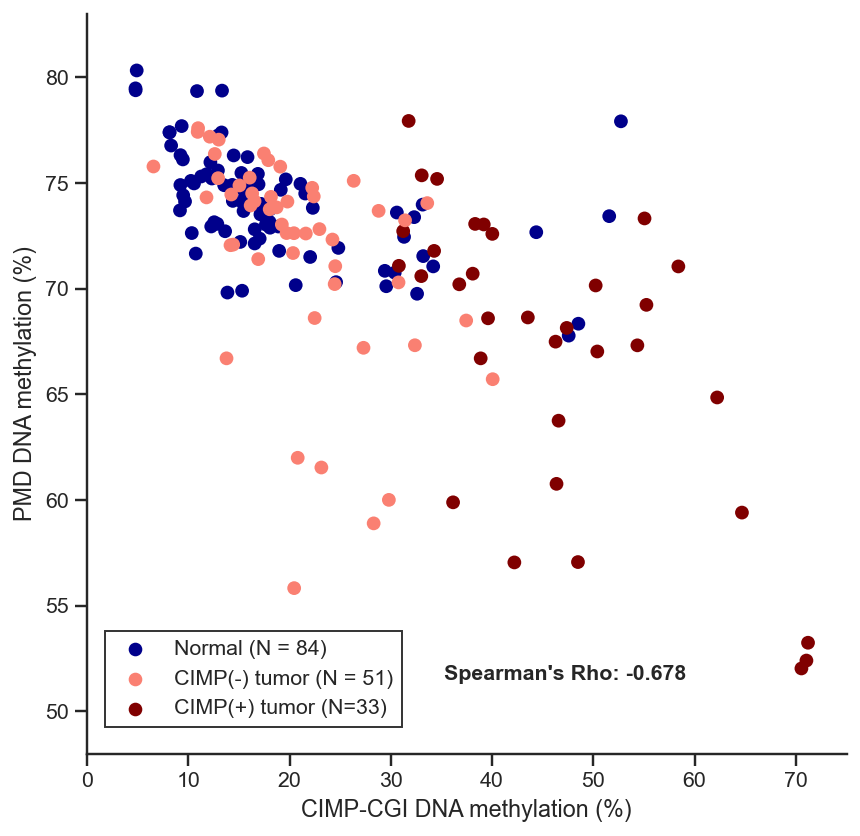

In [22]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.scatterplot(data=cimp_pmd, x='CpGimet', y='PMDmet', hue='CIMPtype', linewidth=0, palette={'Normal (N = 84)': 'darkblue', 'CIMP(-) tumor (N = 51)': 'salmon', 'CIMP(+) tumor (N=33)': 'maroon'}, s=50, ax=ax)
handles, labels = ax.get_legend_handles_labels()
order = [0, 2, 1]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper left', bbox_to_anchor=(0.01, 0.18), frameon=True, edgecolor='black', fancybox=False)
ax.set_xlabel('CIMP-CGI DNA methylation (%)')
ax.set_ylabel('PMD DNA methylation (%)')
ax.text(0.47, 0.1, f"Spearman's Rho: {rho}", size=11, weight='bold', transform=ax.transAxes)
ax.set_xlim((0, 75))
ax.set_ylim((48, 83))
sns.despine(ax=ax)

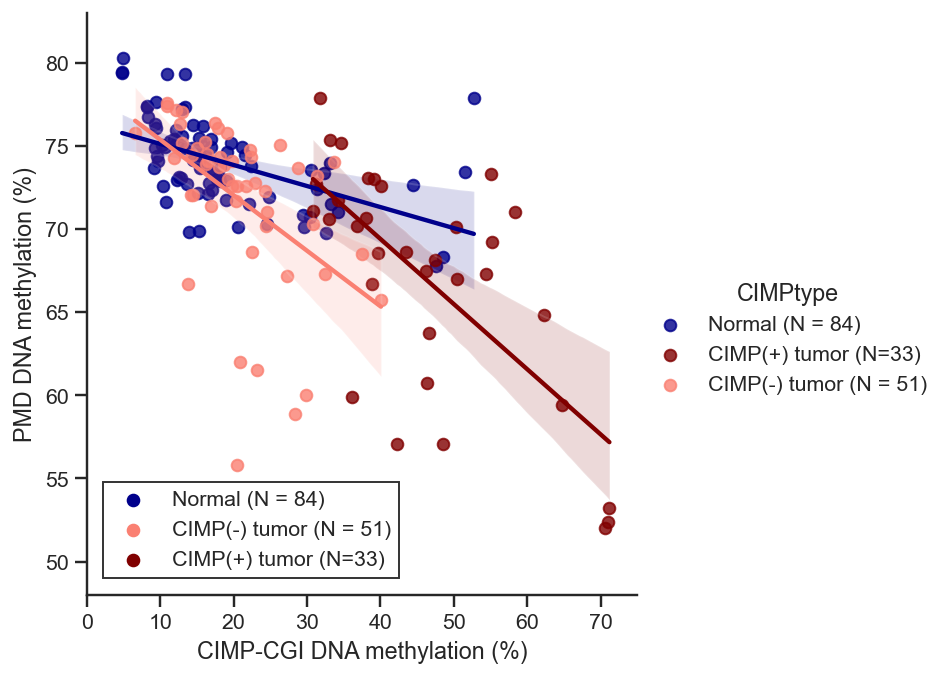

In [23]:
g = sns.lmplot(data=cimp_pmd, x='CpGimet', y='PMDmet', hue='CIMPtype', palette={'Normal (N = 84)': 'darkblue', 'CIMP(-) tumor (N = 51)': 'salmon', 'CIMP(+) tumor (N=33)': 'maroon'})
g.ax.set_xlabel('CIMP-CGI DNA methylation (%)')
g.ax.set_ylabel('PMD DNA methylation (%)')
g.ax.set_xlim((0, 75))
g.ax.set_ylim((48, 83))
g.ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper left', bbox_to_anchor=(0.01, 0.212), frameon=True, edgecolor='black', fancybox=False)

In [24]:
# CIMP proportional plot
#ax = (pd.crosstab(dmr_t.obs['DMR Clusters'], dmr_t.obs['CIMP'], normalize=0)*100).plot.bar(stacked=True, color=['#8b0000ff', '#000080ff'], rot=0)
#plt.ylabel("Proportion (%)")
#ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))
#plt.tight_layout()
#sns.despine()

"\n# Only Tumor    \ng = sns.clustermap(dmr_met,\n                   method='ward',\n                   metric='euclidean',\n                   z_score=None,\n                   standard_scale=None,\n                   cmap='RdYlBu_r',\n                   xticklabels=False,\n                   yticklabels=False,\n                   col_colors=['#C0C0C0']*84 + ['#000000']*84,\n                   row_colors=row_colors_dmr)\ng.ax_heatmap.set_ylabel('')\n"

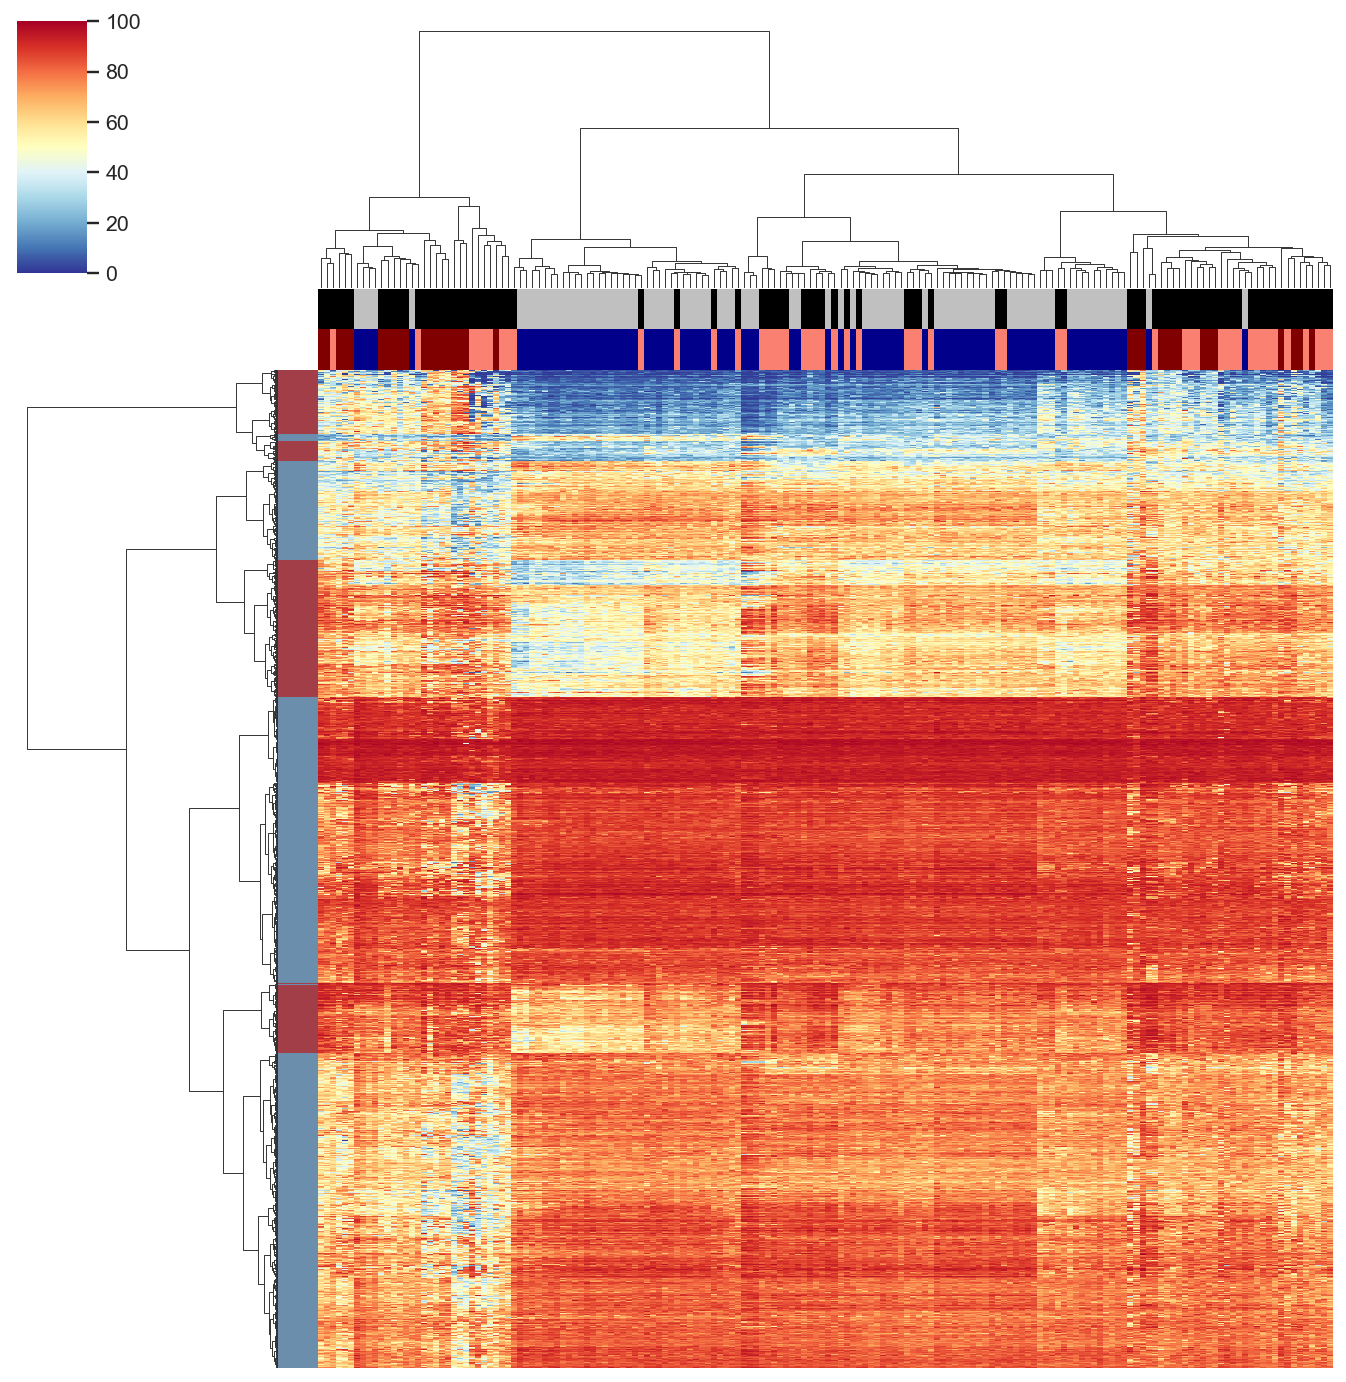

In [28]:
# DMR
dmr_met = pd.read_table(f"{dir}/01.DNA_Methylation/DMR_abs10_smooth.txt", index_col=0)
dmr_met.columns = list(map(lambda x: 'X'+x, dmr_met.columns))
dmr_met = dmr_met*100

dmr_info = pd.read_table(f"{dir}/01.DNA_Methylation/DMR_abs10_Hyper-Hypo_annotation.txt", index_col=0)

# Remove PMD-overlapped Hypo-DMR
with open(f"{dir}/01.DNA_Methylation/DMR_abs10_hypo_wPMD.index", 'r') as dfh:
    hypodmr_wPMD = list(map(lambda x: x.strip(), dfh.readlines()))

dmr_met = dmr_met[~dmr_met.index.isin(hypodmr_wPMD)]
dmr_info = dmr_info[~dmr_info.index.isin(hypodmr_wPMD)]

del hypodmr_wPMD

col_colors_tn = ['#C0C0C0']*84 + ['#000000']*84
col_colors_cimp = list(dict(zip(['Normal (N = 84)', 'CIMP(-) tumor (N = 51)', 'CIMP(+) tumor (N=33)'], ['darkblue', 'salmon', 'maroon']))[x] for x in cimp_pmd['CIMPtype'])
row_colors_dmr = list(dict(zip(['Hypo', 'Hyper'], ['#6C8EAD', '#A23E48']))[x] for x in dmr_info['Type'])


g = sns.clustermap(dmr_met,
                   method='ward',
                   metric='euclidean',
                   z_score=None,
                   standard_scale=None,
                   cmap='RdYlBu_r',
                   xticklabels=False,
                   yticklabels=False,
                   vmin=0,
                   vmax=100,
                   col_colors=[col_colors_tn, col_colors_cimp],
                   row_colors=row_colors_dmr) # standard scale: 0 (rows) or 1 columns (subtract min and divide by max)
g.ax_heatmap.set_ylabel('')
'''
# Only Tumor    
g = sns.clustermap(dmr_met,
                   method='ward',
                   metric='euclidean',
                   z_score=None,
                   standard_scale=None,
                   cmap='RdYlBu_r',
                   xticklabels=False,
                   yticklabels=False,
                   col_colors=['#C0C0C0']*84 + ['#000000']*84,
                   row_colors=row_colors_dmr)
g.ax_heatmap.set_ylabel('')
'''

In [32]:
# RNA expression processing
## DEG results from DESeq2
#deg_tn = pd.read_csv("/data/Projects/phenomata/01.Projects/08.StomachCancer_backup/02.RNA-seq/GENCODE_V24/Tumor.Normal.compare_ComBat.csv", index_col=0)
#deg_genes = deg_tn[(deg_tn['padj'] < 0.01) & (deg_tn['baseMean'] > 10)].index

# Promoter methylation processing
## PLS info
pls_info = pd.read_table(f"{dir}/01.DNA_Methylation/ENCODE_Promoter/PLS_annotated_table_full_new_non-redundant.txt", index_col=0)
## PLS info with DMR
#plsdmr_info = pd.read_table("PLS_annotated_table_full_DMR.txt", index_col=0)
## NO-PLS info
nopls_info = pd.read_table(f"{dir}/01.DNA_Methylation/ENCODE_Promoter/No_PLS_annotated_table_full_new.txt", index_col=0)
## NO-PLS info with DMR
#noplsdmr_info = pd.read_table("No_PLS_annotated_table_full_DMR.txt", index_col=0)

## Gene-biotype used downstream
used_info = ['protein_coding',
             'lincRNA',
             '3prime_overlapping_ncRNA',
             'antisense',
             'bidirectional_promoter_lncRNA',
             'macro_lncRNA',
             'non_coding',
             'processed_transcript',
             'sense_intronic',
             'sense_overlapping']
pls_info = pls_info[pls_info['Type'].isin(used_info)]
nopls_info = nopls_info[nopls_info['Type'].isin(used_info)]
nopls_info = nopls_info[~nopls_info['GeneID'].isin(pls_info['GeneID'])]

#plsdmr_info = plsdmr_info[plsdmr_info['Type'].isin(used_info)]
#noplsdmr_info = noplsdmr_info[noplsdmr_info['Type'].isin(used_info)]
#noplsdmr_info = noplsdmr_info[~noplsdmr_info['GeneID'].isin(plsdmr_info['GeneID'])]

pls = pd.read_table(f"{dir}/01.DNA_Methylation/ENCODE_Promoter/cCRE_PLS_smooth_modified.txt", index_col=0)
nopls = pd.read_table(f"{dir}/01.DNA_Methylation/ENCODE_Promoter/NO_PLS_smooth_modified.txt", index_col=0)
pls.columns = list(map(lambda x: 'X'+x, pls.columns))
nopls.columns = list(map(lambda x: 'X'+x, nopls.columns))
pls = pls[pls.index.isin(list(map(lambda x:'/'.join(x.split('/')[:-1]), pls_info.index)))]
nopls = nopls[nopls.index.isin(list(map(lambda x:'/'.join(x.split('/')[:-1]), nopls_info.index)))]

comb_pls = pd.concat([pls, nopls])
comb_pls = comb_pls*100
comb_pls_info = pd.concat([pls_info, nopls_info])
comb_pls.index = comb_pls_info.index

#comb_plsdmr_info = pd.concat([plsdmr_info, noplsdmr_info])
#comb_plsdmr = comb_pls[comb_pls.index.isin(comb_plsdmr_info.index)]
#comb_plsdmr = comb_plsdmr
#comb_plsdmr_info = comb_plsdmr_info[comb_plsdmr_info.index.isin(comb_plsdmr.index)]

del pls, nopls, pls_info, nopls_info


In [31]:
## Combat-corrected transcript-level counts
trans_combat = pd.read_table(f"{dir}/02.RNA/STAD_SNUH_tx_combat_norm_counts.txt", index_col=0, sep=' ')
trans_combat.columns = list(map(lambda x: 'X'+x, trans_combat.columns))

## Combat-corrected transcript-level log2(counts+1)
trans_combat_log2 = np.log2(trans_combat + 1)
del trans_combat


In [37]:
comb_pls_info

,Region,cCRE_ID,GeneID,ENSGID,ENSTID,Type,CpGnum,CpGdensity,CpGi,ATAC,K4me3,K27ac,K4me1,K27me3,K36me3
ID,,,,,,,,,,,,,,,
chr1:778470-779019/EH38D4327580/RP11-206L10.2/ENSG00000228327/ENST00000506640/processed_transcript/47,chr1:778470-779019,EH38D4327580,RP11-206L10.2,ENSG00000228327,ENST00000506640,processed_transcript,47,85.610200,Yes,Yes,Yes,Yes,Yes,na,na
chr1:778470-779019/EH38D4327580/RP11-206L10.9/ENSG00000237491/ENST00000434264/lincRNA/47,chr1:778470-779019,EH38D4327580,RP11-206L10.9,ENSG00000237491,ENST00000434264,lincRNA,47,85.610200,Yes,Yes,Yes,Yes,Yes,na,na
chr1:778470-779019/EH38D4327580/RP11-206L10.9/ENSG00000237491/ENST00000457084/lincRNA/47,chr1:778470-779019,EH38D4327580,RP11-206L10.9,ENSG00000237491,ENST00000457084,lincRNA,47,85.610200,Yes,Yes,Yes,Yes,Yes,na,na
chr1:778926-779280/EH38D4327581/RP11-206L10.9/ENSG00000237491/ENST00000429505/lincRNA/32,chr1:778926-779280,EH38D4327581,RP11-206L10.9,ENSG00000237491,ENST00000429505,lincRNA,32,90.395480,Yes,Yes,Yes,Yes,na,na,na
chr1:816980-817503/EH38D2115333/FAM87B/ENSG00000177757/ENST00000326734/lincRNA/8,chr1:816980-817503,EH38D2115333,FAM87B,ENSG00000177757,ENST00000326734,lincRNA,8,15.296367,na,Yes,na,Yes,na,na,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:155467785-155468786/NoPLS_21514/RP11-218L14.4/ENSG00000225393/ENST00000447347/antisense/4,chrX:155467785-155468786,NoPLS_21514,RP11-218L14.4,ENSG00000225393,ENST00000447347,antisense,4,3.996004,na,na,na,na,na,na,na
chrX:155767311-155768312/NoPLS_21515/SPRY3/ENSG00000168939/ENST00000302805/protein_coding/22,chrX:155767311-155768312,NoPLS_21515,SPRY3,ENSG00000168939,ENST00000302805,protein_coding,22,21.978022,na,Yes,Yes,Yes,na,na,na
chrX:156016336-156017337/NoPLS_21517/WASIR1/ENSG00000185203/ENST00000399966/antisense/47,chrX:156016336-156017337,NoPLS_21517,WASIR1,ENSG00000185203,ENST00000399966,antisense,47,46.953047,Yes,Yes,na,na,na,na,na


Ttest_indResult(statistic=array([159.74880141]), pvalue=array([0.]))

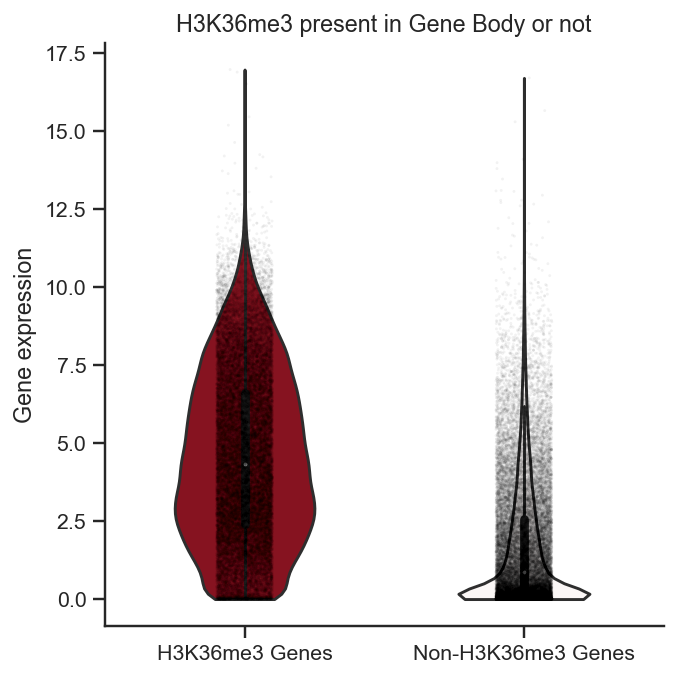

In [46]:
# K36me3 effect (Normal)
a = pd.DataFrame(trans_combat_log2[trans_combat_log2.index.isin(list(comb_pls_info[comb_pls_info['K36me3'] == 'Yes']['ENSTID'].values))].iloc[:,:84].mean(axis=1), columns=['H3K36me3 Genes'])
b = pd.DataFrame(trans_combat_log2[trans_combat_log2.index.isin(list(comb_pls_info[comb_pls_info['K36me3'] == 'na']['ENSTID'].values))].iloc[:,:84].mean(axis=1), columns=['Non-H3K36me3 Genes'])
ab = pd.concat([a,b], axis=1)
p = sns.violinplot(data=ab, palette={'H3K36me3 Genes':'#990011FF', 'Non-H3K36me3 Genes':'#FCF6F5FF'}, width=0.5, showfliers = False, scale='count', cut=0)
p = sns.stripplot(data=ab, jitter=True, marker='o', color='black', size=1.5, alpha=0.05)
p.set_ylabel("Gene expression")
p.set_title("H3K36me3 present in Gene Body or not")
plt.tight_layout()
sns.despine()
stats.ttest_ind(a, b)